# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

- artist: The name of the artist associated with the song being played.
- auth: The authentication status of the user, indicating whether the user is logged in or logged out.
- firstName: The first name of the user.
- gender: The gender of the user.
- itemInSession: The index of the item within the user's session.
- lastName: The last name of the user.
- length: The duration of the song being played.
- level: The subscription level of the user (free or paid).
- location: The location of the user.
- method: The HTTP method used for the request (GET or PUT).
- page: The specific page or action the user performed (e.g., "NextSong", "Thumbs Up", "Add to Playlist").
- registration: The timestamp when the user registered.
- sessionId: The ID of the user's session.
- song: The title of the song being played.
- status: The HTTP status code of the response.
- ts: The timestamp of the event.
- userAgent: The user agent string of the user's browser or client.
- userId: The unique identifier of the user.

**Objective** to define a model the predict the users' potential negative behaviour - cancel, downgrade - based on the users basic json info

In [165]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, sum as sql_sum, avg, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify Data Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [167]:
%ls

mini_sparkify_event_data.json  Sparkify.ipynb  Sparkify-zh.ipynb


In [168]:
file_path = "mini_sparkify_event_data.json"
# read the data via spark
sc = spark.read.json(file_path)

In [169]:
sc.printSchema()
sc.show(5)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     

In [170]:
# Convert data types
columns_to_cast = {
    "userId": "Integer",
    "length": "Double"
}

for column, dtype in columns_to_cast.items():
    sc = sc.withColumn(column, sc[column].cast(dtype))

In [171]:
sc.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [172]:
# convert it to pandas dataframe for a better overview
df = sc.toPandas()

In [173]:
df.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId            8346
dtype: int64

In [174]:
df.length.isnull().sum()/df.shape[0]*100

20.381151832460734

> There are 20% of missing data in length, try to imputate the missing data with respect to length

In [175]:
# compute the mean length for each userID
mean_length = sc.groupBy('userId').agg(avg('length').alias('mean_length'))

# join the mean lengths back to the original DataFrame
sc_length = sc.join(mean_length, on='userId', how='left')

# fill null values
sc_filled = sc_length.withColumn(
    'length_filled',when(sc_length['length'].isNull(), sc_length['mean_length']).otherwise(sc_length['length'])
)
# drop columns and rename the length_filled to length
sc_filled = sc_filled.drop('length','mean_length').withColumnRenamed('length_filled', 'length')

In [176]:
sc_filled.toPandas().isnull().sum()

userId            8346
artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
length            8346
dtype: int64

> From the above columns and the number of null values in each, the parameters that may determine the user behaviour may cover: gender, itemInSession, level, location, method, page, sessionId, status, ts, and userId. Using these parameters can minimise the null value to be dropped and give the maximum parameters for the model training

In [177]:
df = sc_filled.toPandas()

In [178]:
df.page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
       'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [179]:
df.describe()

,userId,itemInSession,registration,sessionId,status,ts,length
count,278154.000000,286500.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05,278154.000000
mean,59682.022786,114.414213,1.535359e+12,1041.526555,210.054597,1.540957e+12,249.106413
std,109091.949999,129.767262,3.291322e+09,726.776263,31.505078,1.507544e+09,89.875595
min,2.000000,0.000000,1.521381e+12,1.000000,200.000000,1.538352e+12,0.783220
25%,51.000000,27.000000,1.533522e+12,336.000000,200.000000,1.539697e+12,207.986490
50%,98.000000,70.000000,1.536664e+12,1013.000000,200.000000,1.540932e+12,246.056378
75%,100004.000000,156.250000,1.537672e+12,1675.000000,200.000000,1.542266e+12,265.743220
max,300025.000000,1321.000000,1.543247e+12,2474.000000,404.000000,1.543799e+12,3024.665670


In [180]:
sc = sc_filled

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [181]:
sc.show(5)

+------+----------------+---------+---------+------+-------------+--------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+---------+
|userId|          artist|     auth|firstName|gender|itemInSession|lastName|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|   length|
+------+----------------+---------+---------+------+-------------+--------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+---------+
|    30|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|277.89016|
|     9|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|    

In [182]:
# rename the column names
from pyspark.sql.types import StringType
to_lower_coln = udf(lambda x: x.lower(), StringType())

In [183]:
for col in sc.columns:
    sc.withColumn(col, to_lower_coln(col))

In [184]:
# select the relevant columns
coln_selected = ['gender', 'itemInSession', 'level', 'location', 'length', 'method', 'page', 'sessionId', 'status', 'ts', 'userId']
sc_sl = sc.select(coln_selected)

In [185]:
# drop na and duplicated
sc_cl = sc_sl.dropna()
sc_cl = sc_cl.dropDuplicates()

In [186]:
# add a column of churn
to_label_churn = udf(lambda x: 2 if x == 'Cancellation Confirmation' else 1 if x == 'Downgrade' else 0)
sc_cl = sc_cl.withColumn('churn', to_label_churn(sc_cl.page))

In [187]:
# convert time
import datetime
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [188]:
sc_cl = sc_cl.withColumn('year', get_year(sc_cl.ts))
sc_cl = sc_cl.withColumn('month', get_month(sc_cl.ts))
sc_cl = sc_cl.withColumn('day', get_day(sc_cl.ts))
sc_cl = sc_cl.withColumn('hour', get_hour(sc_cl.ts))

In [189]:
sc_cl = sc_cl.drop('ts')

In [190]:
# convert the data types
columns_to_cast = {
    'churn': 'Integer',
    'year': 'Integer',
    'month': 'Integer',
    'day': 'Integer',
    'hour': 'Integer'
}

for column, dtype in columns_to_cast.items():
    sc_cl = sc_cl.withColumn(column, sc_cl[column].cast(dtype))

In [191]:
# select on the state as the location
to_extract_state = udf(lambda s: s.split(',')[1].strip() if ',' in s else s)

In [192]:
sc_cl = sc_cl.withColumn('state', to_extract_state(sc_cl.location))

In [193]:
from pyspark.sql.functions import split, explode
sc_cl2 = sc_cl.withColumn('states', split(sc_cl.state, "-"))
sc_cl2 = sc_cl2.withColumn('state', explode(sc_cl2.states))
sc_cl = sc_cl2.drop('states','location')

In [194]:
sc_cl.show(5)

+------+-------------+-----+---------+------+--------+---------+------+------+-----+----+-----+---+----+-----+
|gender|itemInSession|level|   length|method|    page|sessionId|status|userId|churn|year|month|day|hour|state|
+------+-------------+-----+---------+------+--------+---------+------+------+-----+----+-----+---+----+-----+
|     M|           32| free|406.07302|   PUT|NextSong|      100|   200|   101|    0|2018|   10|  1|   4|   CO|
|     F|           62| free|447.79057|   PUT|NextSong|      187|   200|    78|    0|2018|   10|  1|   4|   TX|
|     F|            0| paid|179.46077|   PUT|NextSong|      222|   200|    25|    0|2018|   10|  1|   4|   FL|
|     F|           23| paid|435.93098|   PUT|NextSong|      260|   200|    54|    0|2018|   10|  1|  13|   WA|
|     M|           66| free|284.81261|   PUT|NextSong|       26|   200|    27|    0|2018|   10|  1|  16|   CT|
+------+-------------+-----+---------+------+--------+---------+------+------+-----+----+-----+---+----+-----+
o

> Now the data is wrangled

In [195]:
# convert the sc data to pandas dataframe to visualise for a basic analysis
df_cl = sc_cl.toPandas()

In [222]:
df_pc = df_cl[df_cl.churn == 2]
df_pc.sample(5)

,gender,itemInSession,level,length,method,page,sessionId,status,userId,churn,year,month,day,hour,state
147224,M,65,free,251.372082,GET,Cancellation Confirmation,71,200,100019,2,2018,10,7,22,WA
266745,M,44,paid,250.561308,GET,Cancellation Confirmation,301,200,200017,2,2018,11,15,20,PA
365502,F,51,paid,247.914937,GET,Cancellation Confirmation,165,200,100013,2,2018,11,2,18,OH
388127,M,78,free,254.782041,GET,Cancellation Confirmation,268,200,200018,2,2018,11,2,10,NJ
109356,M,48,paid,248.899992,GET,Cancellation Confirmation,1112,200,58,2,2018,10,22,15,AL


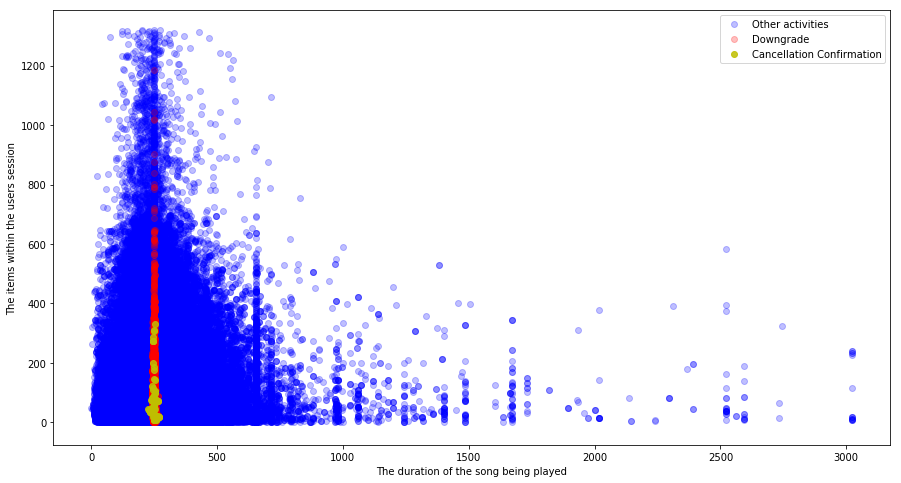

In [239]:
plt.figure(figsize=(15,8))
plt.scatter(x='length', y='itemInSession', data=df_cl[df_cl.churn == 0], c='b', alpha=0.25)
plt.scatter(x='length', y='itemInSession', data=df_cl[df_cl.churn == 1], c='r', alpha=0.25)
plt.scatter(x='length', y='itemInSession', data=df_cl[df_cl.churn == 2], c='y', alpha=0.85)
plt.xlabel('The duration of the song being played')
plt.ylabel('The items within the user''s session')
plt.legend(['Other activities','Downgrade','Cancellation Confirmation'])
plt.show()

**summary** The plot above compares the length of the song played and the activity items in each user's activity session categorised by user's churns. The 'Downgrade' decision is strongly associated with the length of the song being played whilst the 'Cancellation' decision is also strongly associated with the activity items in the user's activity. These can be a strong parameters for determining the potential users with negative decisions on experiencing Sparkify.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# indexing the strings
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [ ]:
for col in sc_cl.columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    sc_ind = indexer.fit(sc_cl).transform(sc_cl)
    sc_ind = sc_ind.drop(col).withColumnRenamed(col + "_index", col)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.